In [19]:
import os
import random
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [20]:
dataset_path = "/kaggle/input/24-letter-of-sibi-sign-language/Dataset_pakai"

In [21]:
# List all folders (each folder represents an alphabet)
alphabet_folders = os.listdir(dataset_path)

# List to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate through each alphabet folder
for alphabet_folder in alphabet_folders:
    # Path to the current alphabet folder
    alphabet_folder_path = os.path.join(dataset_path, alphabet_folder)
    # List all files (images) in the current alphabet folder
    images = os.listdir(alphabet_folder_path)
    # Iterate through each image in the current alphabet folder
    for image in images:
        # Construct the full path to the image file
        image_path = os.path.join(alphabet_folder_path, image)
        # Append the image path to the list of file paths
        file_paths.append(image_path)
        # Append the label (alphabet) to the list of labels
        labels.append(alphabet_folder)

# Create a DataFrame to store the file paths and labels
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Optionally, shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Print the first few rows of the DataFrame
print(df)

                                               file_path label
0      /kaggle/input/24-letter-of-sibi-sign-language/...     L
1      /kaggle/input/24-letter-of-sibi-sign-language/...     E
2      /kaggle/input/24-letter-of-sibi-sign-language/...     N
3      /kaggle/input/24-letter-of-sibi-sign-language/...     O
4      /kaggle/input/24-letter-of-sibi-sign-language/...     K
...                                                  ...   ...
11995  /kaggle/input/24-letter-of-sibi-sign-language/...     W
11996  /kaggle/input/24-letter-of-sibi-sign-language/...     X
11997  /kaggle/input/24-letter-of-sibi-sign-language/...     P
11998  /kaggle/input/24-letter-of-sibi-sign-language/...     K
11999  /kaggle/input/24-letter-of-sibi-sign-language/...     P

[12000 rows x 2 columns]


In [22]:
# Print all alphabet folders
for alphabet_folder in alphabet_folders:
    print(alphabet_folder)

N
R
B
I
F
H
E
U
M
X
K
Q
Y
S
G
A
O
T
V
C
P
L
W
D


In [23]:
from sklearn.model_selection import train_test_split

# Pembagian dataset menjadi set pelatihan dan set validasi (misalnya, 80% pelatihan, 20% validasi)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Print informasi tentang ukuran set pelatihan dan set validasi
print("Jumlah data pelatihan:", len(train_df))
print("Jumlah data validasi:", len(val_df))

Jumlah data pelatihan: 9600
Jumlah data validasi: 2400


In [24]:

# Membuat ImageDataGenerator untuk pelatihan dan validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi untuk data validasi

# Pengkodean label (contoh: one-hot encoding)
num_classes = len(df['label'].unique())
train_labels = to_categorical(train_df['label'].astype('category').cat.codes, num_classes=num_classes)
val_labels = to_categorical(val_df['label'].astype('category').cat.codes, num_classes=num_classes)


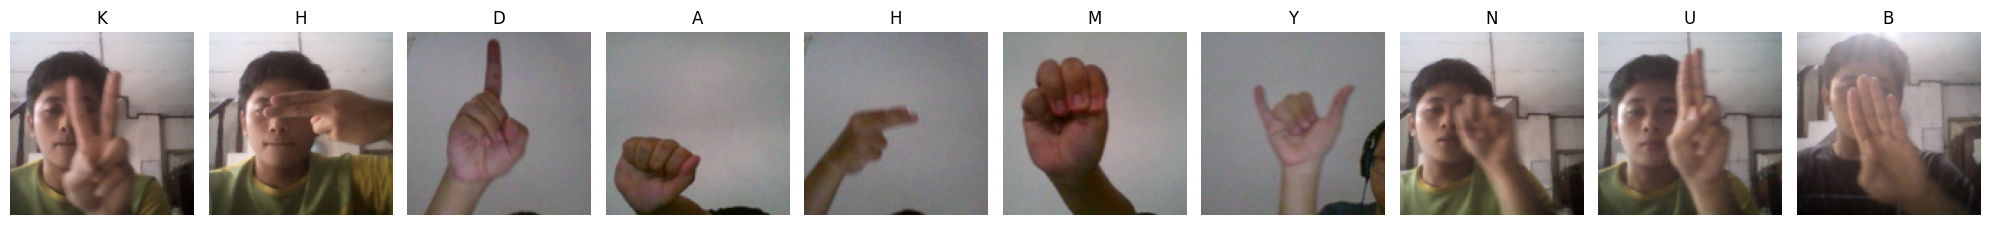

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

# Fungsi untuk memplot 10 gambar dari DataFrame
def plot_sample_images(df):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()

    # Pilih 10 sampel acak dari DataFrame
    sample_df = df.sample(n=10)

    for ax, (index, row) in zip(axes, sample_df.iterrows()):
        img_path = row['file_path']
        label = row['label']

        # Muat gambar
        img = Image.open(img_path)  # Tidak perlu convert ke grayscale jika ingin memplot warna RGB
        img = img.resize((128, 128))  # Sesuaikan ukuran gambar dengan target_size generator

        # Tampilkan gambar
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk memplot sampel dari gambar pelatihan
plot_sample_images(val_df)


In [26]:
# Muat gambar-gambar untuk pelatihan dan validasi
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'  # Setel color_mode ke 'rgb' untuk gambar RGB
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'  # Setel color_mode ke 'rgb' untuk gambar RGB
)

Found 9600 validated image filenames belonging to 24 classes.
Found 2400 validated image filenames belonging to 24 classes.


In [27]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [28]:
model = create_model()

# Define and use the callback directly during fit
class MyCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
            print('\nTraining is done, Accuracy is more than 90%')
            self.model.stop_training = True
callback = MyCallbacks()

history = model.fit(
    train_generator,
    epochs=200,
    callbacks=[callback],  # Use callback here
    validation_data=val_generator
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/300 ━━━━━━━━━━━━━━━━━━━━ 32:10 6s/step - accuracy: 0.0000e+00 - loss: 3.1873

W0000 00:00:1718607933.311327     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.0671 - loss: 3.0829

W0000 00:00:1718608027.651805     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


300/300 ━━━━━━━━━━━━━━━━━━━━ 114s 361ms/step - accuracy: 0.0676 - loss: 3.0809 - val_accuracy: 0.1950 - val_loss: 2.5825
Epoch 2/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.2040 - loss: 2.4924 - val_accuracy: 0.3904 - val_loss: 1.8780
Epoch 3/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 186ms/step - accuracy: 0.3411 - loss: 2.0075 - val_accuracy: 0.4850 - val_loss: 1.4857
Epoch 4/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 185ms/step - accuracy: 0.4427 - loss: 1.6773 - val_accuracy: 0.6313 - val_loss: 1.1875
Epoch 5/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 185ms/step - accuracy: 0.5213 - loss: 1.4332 - val_accuracy: 0.7321 - val_loss: 0.8418
Epoch 6/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 185ms/step - accuracy: 0.5811 - loss: 1.2340 - val_accuracy: 0.7621 - val_loss: 0.7422
Epoch 7/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.6461 - loss: 1.0583 - val_accuracy: 0.7771 - val_loss: 0.6689
Epoch 8/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 189ms/step - accuracy: 0.6913 - loss: 0.90

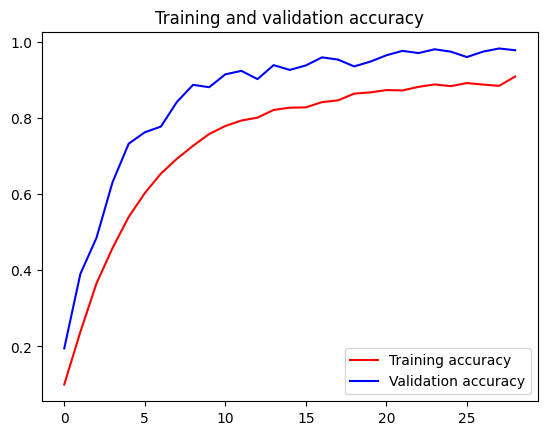

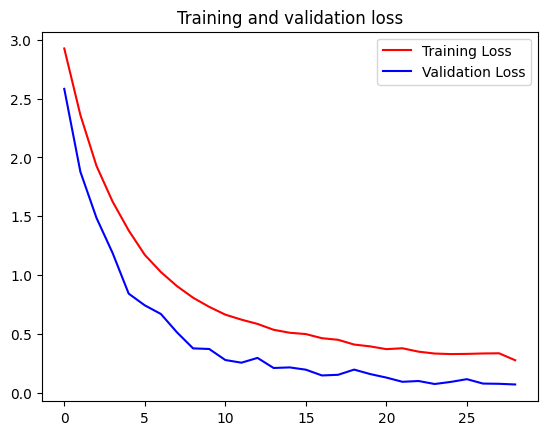

In [30]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
model.save("Signify.h5")

# Convert TFLite